## Fake News Classifier

#### Assumption - Assuming the provided dataset is correctly labeled

In [47]:
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import numpy as np
import re
import pickle
import multiprocessing
from multiprocessing import Process, Manager, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
lemmatizer = WordNetLemmatizer()
sent_tokenizer = PunktSentenceTokenizer()
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, analyzer='word')

In [3]:
train_df = pd.read_csv('../data/train.csv')  # label: 1 -- Fake News <---> label: 0 -- Real News
test_df = pd.read_csv('../data/test.csv')
submit_df = pd.read_csv('../data/submit.csv')

In [4]:
train_df.shape

(20800, 5)

In [5]:
test_df.shape

(5200, 4)

In [6]:
submit_df.shape

(5200, 2)

In [7]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### ClassWise Data Distribution

In [8]:
# Check if data unbalanced data
train_df.groupby('label').count()

,id,title,author,text
label,,,,
0,10387,10387,10361,10387
1,10413,9855,8482,10374


<AxesSubplot:xlabel='label', ylabel='count'>

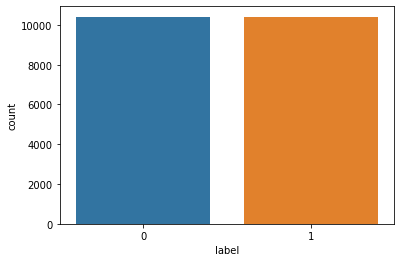

In [9]:
sns.countplot(x=train_df["label"])

### Describe Dataset

In [10]:
train_df.describe(include='all')

,id,title,author,text,label
count,20800.000000,20242,18843,20761,20800.000000
unique,NaN,19803,4201,20386,NaN
top,NaN,The Dark Agenda Behind Globalism And Open Borders,Pam Key,,NaN
freq,NaN,5,243,75,NaN
mean,10399.500000,NaN,NaN,NaN,0.500625
std,6004.587135,NaN,NaN,NaN,0.500012
min,0.000000,NaN,NaN,NaN,0.000000
25%,5199.750000,NaN,NaN,NaN,0.000000
50%,10399.500000,NaN,NaN,NaN,1.000000
75%,15599.250000,NaN,NaN,NaN,1.000000


### NULL value analysis

In [11]:
# Null value analysis
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

### Removing Rows Which Contains Null Values

In [12]:
# train_df = train_df.dropna()
# test_df = test_df.dropna()
train_df = train_df.replace(np.nan, '', regex=True)
test_df = test_df.replace(np.nan, '', regex=True)

In [13]:
# Null value analysis
train_df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [14]:
train_df.shape

(20800, 5)

In [15]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [16]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [17]:
# train_df['title_and_text'] = train_df.text #train_df.title.map(str) + " " + train_df.text
# test_df['title_and_text'] = test_df.text # test_df.title.map(str) + " " + test_df.text

In [18]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [19]:
def text_cleanup(paragraph):
    return re.sub("[\n’“”,^&*()[]{};:,./<>?\|`~-=_+]", " ", paragraph)
#     return paragraph.replace('\n', '').replace('’', '').replace("“", "").replace("”", "").replace(",", "")

In [20]:
def get_sentences(paragraph):
    return sent_tokenizer.tokenize(paragraph)

In [21]:
def get_words(sentence):
    return [word for word in sentence.split() if not word in stopwords.words('english')]

In [22]:
def get_lemmatized_word(word):
    return str(lemmatizer.lemmatize(word))

In [23]:
sentence_corpus = []

In [24]:
def preprocessing(document):
    clean_text = text_cleanup(document)
    sentences = get_sentences(clean_text)
    for sentence in sentences:
        words = get_words(sentence)
        sentence_corpus.append(" ".join(words))

In [25]:
# chunk_list = []
# for chunk_counter in range(0, len(train_df['text']), 1000):
#     doc_tups = tuple([x for x in train_df['text'][chunk_counter: chunk_counter + chunk_size]])
#     chunk_list.append(doc_tups)

In [26]:
# pool = Pool(processes=5)
# pool.map(preprocessing, chunk_list)

In [27]:
# len(sentence_corpus)

### Building Corpus (Train + Test)

In [30]:
# Its one time task, once completed we saved the Vectorizer as a pickled object
"""sentence_corpus = []
count = 0
for text in train_df['text']:
    preprocessing(text)
    count += 1
    print(count)
    
print("started test documents")
for text in test_df['text']:
    preprocessing(text)
    count += 1
    print(count)"""

'sentence_corpus = []\ncount = 0\nfor text in train_df[\'text\']:\n    preprocessing(text)\n    count += 1\n    print(count)\n    \nprint("started test documents")\nfor text in test_df[\'text\']:\n    preprocessing(text)\n    count += 1\n    print(count)'

In [32]:
# Its a one time task
# vectorizer.fit(sentence_corpus)

In [31]:
# Its a one time task
#pickle.dump(vectorizer, open("../data/tfidf_vectorizer.pickle", "wb"))

In [33]:
vectorizer = pickle.load(open("../data/tfidf_vectorizer.pickle", "rb"))

In [ ]:
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

In [34]:
train_vec = vectorizer.transform(train_df['text'])

In [35]:
train_vec.shape

(20800, 202657)

### Model Training & Evaluation - Logistic Regression

In [52]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(train_vec, train_df['label'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
test_vec = vectorizer.transform(test_df['text'])
predicted_result = lr.predict(test_vec)

In [54]:
print(len(predicted_result))

5200


In [55]:
print('\nConfusion matrix\n', confusion_matrix(submit_df['label'], predicted_result))


Confusion matrix
 [[1506  833]
 [1031 1830]]


In [56]:
print(classification_report(submit_df['label'], predicted_result))

              precision    recall  f1-score   support

           0       0.59      0.64      0.62      2339
           1       0.69      0.64      0.66      2861

    accuracy                           0.64      5200
   macro avg       0.64      0.64      0.64      5200
weighted avg       0.65      0.64      0.64      5200



Column: identity_hate


Text(0.5, 1.0, 'Reciever Operating Characteristic')

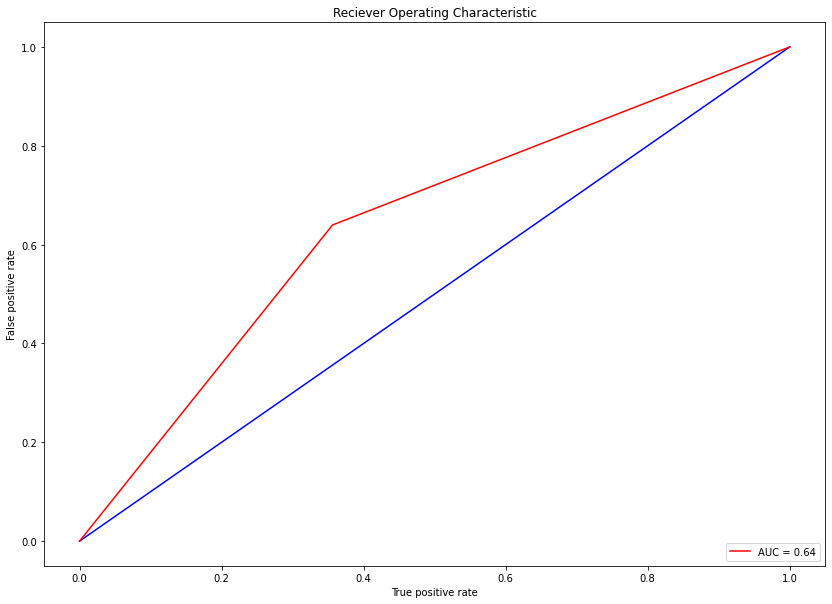

In [41]:
pred_pro = lr.predict(test_vec)
frp,trp,thres = roc_curve(submit_df['label'],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

### Model Training & Evaluation - DecisionTreeClassifier

In [43]:
lr = DecisionTreeClassifier()
lr.fit(train_vec, train_df['label'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [44]:
test_vec = vectorizer.transform(test_df['text'])
predicted_result = lr.predict(test_vec)

In [45]:
print('\nConfusion matrix\n', confusion_matrix(submit_df['label'], predicted_result))


Confusion matrix
 [[1493  846]
 [1101 1760]]


In [46]:
print(classification_report(submit_df['label'], predicted_result))

              precision    recall  f1-score   support

           0       0.58      0.64      0.61      2339
           1       0.68      0.62      0.64      2861

    accuracy                           0.63      5200
   macro avg       0.63      0.63      0.62      5200
weighted avg       0.63      0.63      0.63      5200



### Model Training and Evaluation - RandomForestClassifier

In [57]:
lr = RandomForestClassifier(n_estimators= 1000, random_state=100)
lr.fit(train_vec, train_df['label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [58]:
test_vec = vectorizer.transform(test_df['text'])
predicted_result = lr.predict(test_vec)

In [59]:
print('\nConfusion matrix\n', confusion_matrix(submit_df['label'], predicted_result))


Confusion matrix
 [[1670  669]
 [1054 1807]]


In [60]:
print(classification_report(submit_df['label'], predicted_result))

              precision    recall  f1-score   support

           0       0.61      0.71      0.66      2339
           1       0.73      0.63      0.68      2861

    accuracy                           0.67      5200
   macro avg       0.67      0.67      0.67      5200
weighted avg       0.68      0.67      0.67      5200



Text(0.5, 1.0, 'Reciever Operating Characteristic')

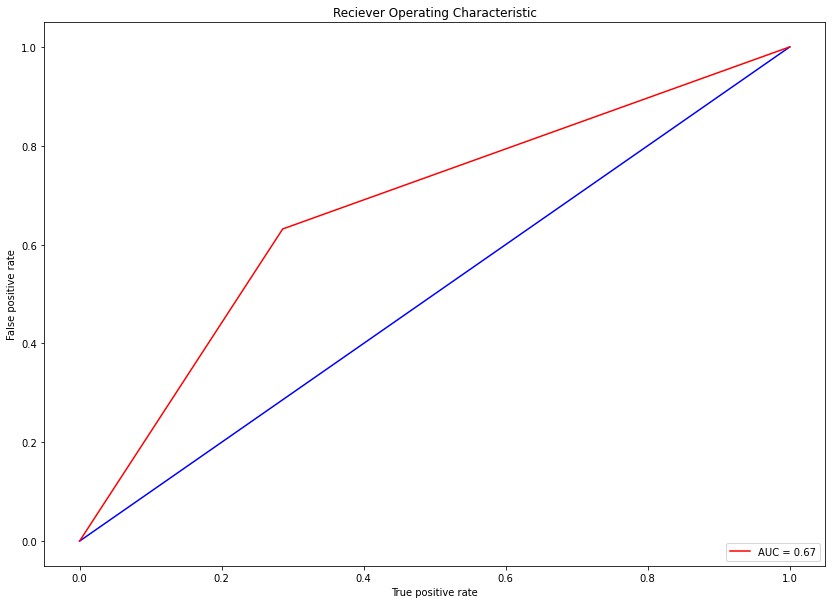

In [61]:
pred_pro = lr.predict(test_vec)
frp,trp,thres = roc_curve(submit_df['label'],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

### Random Forest Performed Best As Compare To Others

In [64]:
new_submit_df = pd.DataFrame()
new_submit_df['id'] = test_df['id']
new_submit_df['label'] = pred_pro

In [65]:
new_submit_df.shape

(5200, 2)

In [66]:
new_submit_df.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [67]:
new_submit_df.to_csv("../data/new_submission.csv", index=False)